In [104]:
import sys
sys.path.insert(0,'..')

from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import ujson as json
import re

from ue4nlp.ue_scores import *
from ue4nlp.ue_variation_ratio import ue_variation_ratio

from utils.plot_error_detection import * 
from utils.plot_error_detection import draw_charts
from utils.plot_error_detection import create_chart_data

import matplotlib.pyplot as plt
from utils.plot_error_detection import plot_error_detection, plot_rejection_curve_aucs

In [105]:
ratio_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [106]:
dataset = 'sst2'

In [107]:
maha_scores = []
res_path = f'../../../new_results/metric_electra_wide/{dataset}/maha/results'

for seed in os.listdir(res_path):

    with open(Path(res_path)/ seed / 'dev_inference.json') as f:
            model_outputs = json.loads(f.read())

    mahalanobis_distance = np.asarray(model_outputs['mahalanobis_distance'])
    probabilities = np.asarray(model_outputs['probabilities'])
    eval_labels = np.asarray(model_outputs['eval_labels'])

    predictions = np.argmax(probabilities, axis=-1)
    
    ensemble_answers = predictions
    sorted_indexes_ensemble = np.argsort(-mahalanobis_distance)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    maha_scores.append(ens_scores)
maha_scores = np.median(maha_scores, axis=0)

In [108]:
mdsn_scores = []
res_path = f'../../workdir/run_tasks_for_model_series_sn/electra_raw_sn/{dataset}/0.0/mahalanobis/results'

for seed in os.listdir(res_path):

    with open(Path(res_path)/ seed / 'dev_inference.json') as f:
            model_outputs = json.loads(f.read())

    mahalanobis_distance = np.asarray(model_outputs['mahalanobis_distance'])
    probabilities = np.asarray(model_outputs['probabilities'])
    eval_labels = np.asarray(model_outputs['eval_labels'])

    predictions = np.argmax(probabilities, axis=-1)
    
    ensemble_answers = predictions
    sorted_indexes_ensemble = np.argsort(-mahalanobis_distance)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    mdsn_scores.append(ens_scores)
mdsn_scores = np.median(mdsn_scores, axis=0)

In [109]:
dpp_scores = []
res_path = f'../../workdir/run_tasks_for_model_series/electra_reg_no_sn/{dataset}/0.0/ddpp_dpp/results'

for seed in os.listdir(res_path):
    with open(Path(res_path) / seed / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())

    probabilities = np.asarray(model_outputs["probabilities"])
    true_labels = np.asarray(model_outputs["true_labels"])
    sampled_probabilities = np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2)
    answers = np.asarray(model_outputs['answers'])

    predictions = np.argmax(probabilities, axis=-1)
    errors = (eval_labels != predictions).astype("uint8")

    smp_dpp = sampled_max_prob(sampled_probabilities)
    pv_dpp = probability_variance(sampled_probabilities)
    
    ensemble_answers = np.asarray(sampled_probabilities).mean(1).argmax(-1)
    sorted_indexes_ensemble = np.argsort(-pv_dpp)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    dpp_scores.append(ens_scores)
dpp_scores = np.median(dpp_scores, axis=0)

In [110]:
de_scores = []
res_path = f'../../../new_results/electra_wide_90_{dataset}/electra_wide_90/ensembles/final_results/0'
for seed in os.listdir(res_path):
    with open(Path(res_path) / seed / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())

    probabilities = np.asarray(model_outputs["probabilities"])
    true_labels = np.asarray(model_outputs["true_labels"])
    sampled_probabilities = np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2)
    answers = np.asarray(model_outputs['answers'])

    de_all_sampled = probability_variance(sampled_probabilities)
    ensemble_answers = np.asarray(sampled_probabilities).mean(1).argmax(-1)
    sorted_indexes_ensemble = np.argsort(-de_all_sampled)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    de_scores.append(ens_scores)
de_scores = np.median(de_scores, axis=0)

In [111]:
mc_scores = []
res_path = f'../../../new_results/metric_electra_wide/{dataset}/all/results'

for seed in os.listdir(res_path):
    
    with open(Path(res_path) / seed / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())

    probabilities = np.asarray(model_outputs["probabilities"])
    true_labels = np.asarray(model_outputs["true_labels"])
    sampled_probabilities = np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2)
    answers = np.asarray(model_outputs['answers'])

    mc_all_sampled = bald(sampled_probabilities)
    ensemble_answers = np.asarray(sampled_probabilities).mean(1).argmax(-1)
    sorted_indexes_ensemble = np.argsort(-mc_all_sampled)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    mc_scores.append(ens_scores)
mc_scores = np.median(mc_scores, axis=0)

In [112]:
sr_scores = []
acc = []
res_path = f'../../../new_results/raw_electra_wide/{dataset}/all/results'

for seed in os.listdir(res_path):

    with open(Path(res_path) / seed / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())

    probabilities = np.asarray(model_outputs["probabilities"])
    true_labels = np.asarray(model_outputs["true_labels"])
    sampled_probabilities = np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2)
    answers = np.asarray(model_outputs['answers'])
    model_ues = 1 - np.max(probabilities, axis=1)
    model_answers = np.asarray(model_outputs['answers'])
    sorted_indexes_model = np.argsort(-model_ues)
    model_scores = [
        get_score_ratio(sorted_indexes_model, model_answers, eval_labels, ratio)
        for ratio in ratio_list
    ]
    sr_scores.append(model_scores)
    acc.append((answers==true_labels).sum() / len(answers))
sr_scores = np.median(sr_scores, axis=0)
acc = np.mean(acc)

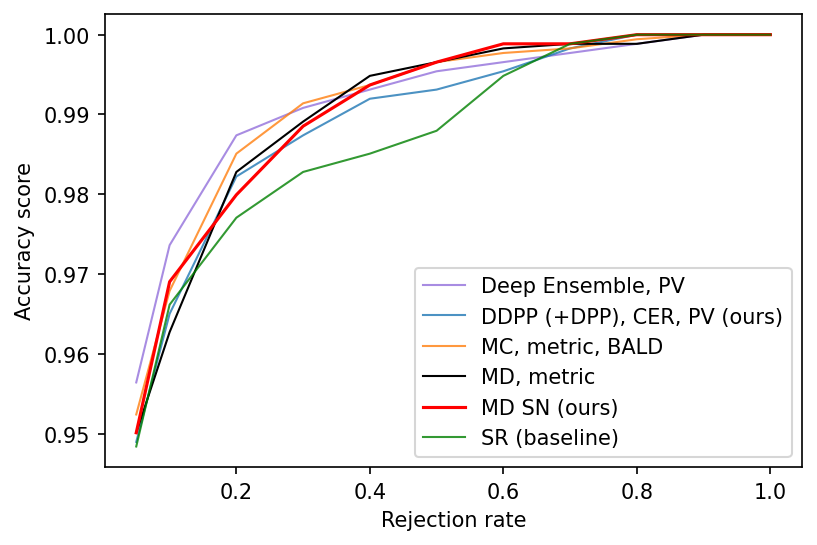

In [113]:
#plt.style.use('seaborn')

plt.figure(dpi=150)
ratio_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

plt.plot(ratio_list, de_scores, label='Deep Ensemble, PV', linewidth=1,  c='mediumpurple', alpha=0.8)
plt.plot(ratio_list, dpp_scores, label='DDPP (+DPP), CER, PV (ours)', linewidth=1, alpha=0.8)
plt.plot(ratio_list, mc_scores, label='MC, metric, BALD', linewidth=1, alpha=0.8)
plt.plot(ratio_list, maha_scores, label='MD, metric', linewidth=1, c='black')
plt.plot(ratio_list, mdsn_scores, label='MD SN (ours)', linewidth=1.5, c='r')        
plt.plot(ratio_list, sr_scores, label="SR (baseline)", linewidth=1, c='g', alpha=0.8)
plt.ylabel("Accuracy score", fontdict={"size": 10})
plt.xlabel("Rejection rate", fontdict={"size": 10})
plt.legend()
plt.savefig(f'../../../arc_plots/{dataset}.pdf')  
plt.savefig(f'../../../arc_plots/{dataset}.png')  

In [114]:
ratio_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
ratio = 2

print(f"Deep Ensemble, ratio={ratio_list[ratio]}, score={de_scores[ratio]}:")
print(f"DDPP, ratio={ratio_list[ratio]}, score={dpp_scores[ratio]}:")
print(f"MC, ratio={ratio_list[ratio]}, score={mc_scores[ratio]}:")
print(f"MD, ratio={ratio_list[ratio]}, score={maha_scores[ratio]}:")
print(f"MD SN, ratio={ratio_list[ratio]}, score={mdsn_scores[ratio]}:")
print(f"SR, ratio={ratio_list[ratio]}, score={sr_scores[ratio]}:")

Deep Ensemble, ratio=0.2, score=0.9873853211009175:
DDPP, ratio=0.2, score=0.9822247706422018:
MC, ratio=0.2, score=0.9850917431192661:
MD, ratio=0.2, score=0.9827981651376146:
MD SN, ratio=0.2, score=0.9799311926605505:
SR, ratio=0.2, score=0.9770642201834863:


In [115]:
dataset = 'mrpc'

In [116]:
maha_scores = []
res_path = f'../../../new_results/cer_electra_wide/{dataset}/maha/results'

for seed in os.listdir(res_path):

    with open(Path(res_path)/ seed / 'dev_inference.json') as f:
            model_outputs = json.loads(f.read())

    mahalanobis_distance = np.asarray(model_outputs['mahalanobis_distance'])
    probabilities = np.asarray(model_outputs['probabilities'])
    eval_labels = np.asarray(model_outputs['eval_labels'])

    predictions = np.argmax(probabilities, axis=-1)
    
    ensemble_answers = predictions
    sorted_indexes_ensemble = np.argsort(-mahalanobis_distance)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    maha_scores.append(ens_scores)
maha_scores = np.median(maha_scores, axis=0)

In [117]:
mdsn_scores = []
res_path = f'../../workdir/run_tasks_for_model_series_sn/electra_metric_sn/{dataset}/0.0/mahalanobis/results'

for seed in os.listdir(res_path):

    try:
        seed = str(int(seed))
    except:
        continue
        
    with open(Path(res_path)/ seed / 'dev_inference.json') as f:
            model_outputs = json.loads(f.read())

    mahalanobis_distance = np.asarray(model_outputs['mahalanobis_distance'])
    probabilities = np.asarray(model_outputs['probabilities'])
    eval_labels = np.asarray(model_outputs['eval_labels'])

    predictions = np.argmax(probabilities, axis=-1)
    
    ensemble_answers = predictions
    sorted_indexes_ensemble = np.argsort(-mahalanobis_distance)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    mdsn_scores.append(ens_scores)
mdsn_scores = np.median(mdsn_scores, axis=0)

In [118]:
dpp_scores = []
res_path = f'../../workdir/run_tasks_for_model_series/electra_reg_no_sn/{dataset}/0.0/ddpp_ood/results'

for seed in os.listdir(res_path):
    with open(Path(res_path) / seed / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())

    probabilities = np.asarray(model_outputs["probabilities"])
    true_labels = np.asarray(model_outputs["true_labels"])
    sampled_probabilities = np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2)
    answers = np.asarray(model_outputs['answers'])

    predictions = np.argmax(probabilities, axis=-1)
    errors = (eval_labels != predictions).astype("uint8")

    smp_dpp = sampled_max_prob(sampled_probabilities)
    pv_dpp = probability_variance(sampled_probabilities)
    
    ensemble_answers = np.asarray(sampled_probabilities).mean(1).argmax(-1)
    sorted_indexes_ensemble = np.argsort(-smp_dpp)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    dpp_scores.append(ens_scores)
dpp_scores = np.median(dpp_scores, axis=0)

In [119]:
de_scores = []
res_path = f'../../../new_results/electra_wide_90_{dataset}/electra_wide_90/ensembles/final_results/0'
for seed in os.listdir(res_path):
    with open(Path(res_path) / seed / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())

    probabilities = np.asarray(model_outputs["probabilities"])
    true_labels = np.asarray(model_outputs["true_labels"])
    sampled_probabilities = np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2)
    answers = np.asarray(model_outputs['answers'])

    de_all_sampled = sampled_max_prob(sampled_probabilities)
    ensemble_answers = np.asarray(sampled_probabilities).mean(1).argmax(-1)
    sorted_indexes_ensemble = np.argsort(-de_all_sampled)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    de_scores.append(ens_scores)
de_scores = np.median(de_scores, axis=0)

In [120]:
mc_scores = []
res_path = f'../../../new_results/cer_electra_wide/{dataset}/all/results'

for seed in os.listdir(res_path):
    
    with open(Path(res_path) / seed / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())

    probabilities = np.asarray(model_outputs["probabilities"])
    true_labels = np.asarray(model_outputs["true_labels"])
    sampled_probabilities = np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2)
    answers = np.asarray(model_outputs['answers'])

    mc_all_sampled = probability_variance(sampled_probabilities)
    ensemble_answers = np.asarray(sampled_probabilities).mean(1).argmax(-1)
    sorted_indexes_ensemble = np.argsort(-mc_all_sampled)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    mc_scores.append(ens_scores)
mc_scores = np.median(mc_scores, axis=0)

In [121]:
ratio_list = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [122]:
sr_scores = []
acc = []
res_path = f'../../../new_results/raw_electra_wide/{dataset}/all/results'

for seed in os.listdir(res_path):

    with open(Path(res_path) / seed / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())

    probabilities = np.asarray(model_outputs["probabilities"])
    true_labels = np.asarray(model_outputs["true_labels"])
    sampled_probabilities = np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2)
    answers = np.asarray(model_outputs['answers'])
    model_ues = 1 - np.max(probabilities, axis=1)
    model_answers = np.asarray(model_outputs['answers'])
    sorted_indexes_model = np.argsort(-model_ues)
    model_scores = [
        get_score_ratio(sorted_indexes_model, model_answers, eval_labels, ratio)
        for ratio in ratio_list
    ]
    sr_scores.append(model_scores)
    acc.append((answers==true_labels).sum() / len(answers))
sr_scores = np.median(sr_scores, axis=0)
acc = np.mean(acc)

In [123]:
sr_scores = sr_scores[1:]

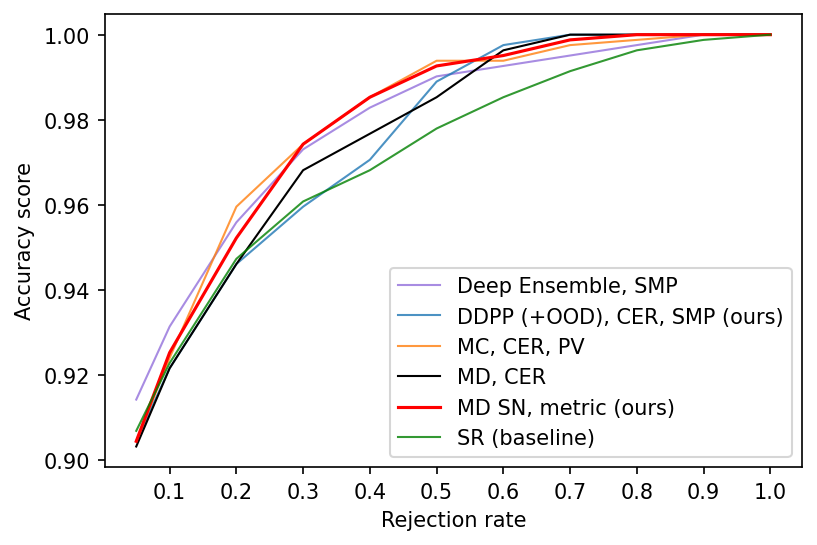

In [129]:
#plt.style.use('seaborn')

plt.figure(dpi=150)
ratio_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

plt.plot(ratio_list, de_scores, label='Deep Ensemble, SMP', linewidth=1,  c='mediumpurple', alpha=0.8)
plt.plot(ratio_list, dpp_scores, label='DDPP (+OOD), CER, SMP (ours)', linewidth=1, alpha=0.8)
plt.plot(ratio_list, mc_scores, label='MC, CER, PV', linewidth=1, alpha=0.8)
plt.plot(ratio_list, maha_scores, label='MD, CER', linewidth=1, c='black')
plt.plot(ratio_list, mdsn_scores, label='MD SN, metric (ours)', linewidth=1.5, c='r')
plt.plot(ratio_list, sr_scores, label="SR (baseline)", linewidth=1, c='g', alpha=0.8)
plt.ylabel("Accuracy score", fontdict={"size": 10})
plt.xlabel("Rejection rate", fontdict={"size": 10})
xticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.xticks(xticks)
plt.legend()
plt.savefig(f'../../../arc_plots/{dataset}.pdf')  
plt.savefig(f'../../../arc_plots/{dataset}.png')  

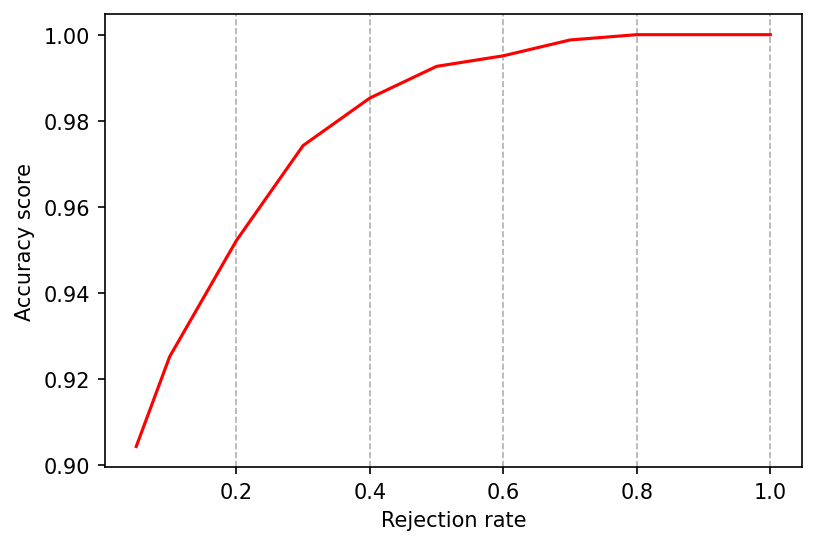

In [85]:
plt.figure(dpi=150)
ratio_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

plt.plot(ratio_list, mdsn_scores, linewidth=1.5, c='r')
plt.grid(axis='x', linestyle='--')
plt.ylabel("Accuracy score", fontdict={"size": 10})
plt.xlabel("Rejection rate", fontdict={"size": 10})
plt.savefig(f'../../../arc_plots/{dataset}_demo.png')  

In [86]:
def rcc_auc(conf, risk, return_points=False):
    # risk-coverage curve's area under curve
    n = len(conf)
    cr_pair = list(zip(conf, risk))
    cr_pair.sort(key=lambda x: x[0], reverse=True)

    cumulative_risk = [cr_pair[0][1]]
    for i in range(1, n):
        cumulative_risk.append(cr_pair[i][1] + cumulative_risk[-1])

    points_x = []
    points_y = []

    auc = 0
    for k in range(n):
        auc += cumulative_risk[k] / (1 + k)
        points_x.append((1 + k) / n)  # coverage
        points_y.append(cumulative_risk[k] / (1 + k))  # current avg. risk

    if return_points:
        return auc, points_x, points_y
    else:
        return auc

    
predictions = np.argmax(probabilities, axis=-1)
risk_binary = (predictions != eval_labels).astype(int)

auc, points_x, points_y = rcc_auc(-mahalanobis_distance, risk_binary, return_points=True)

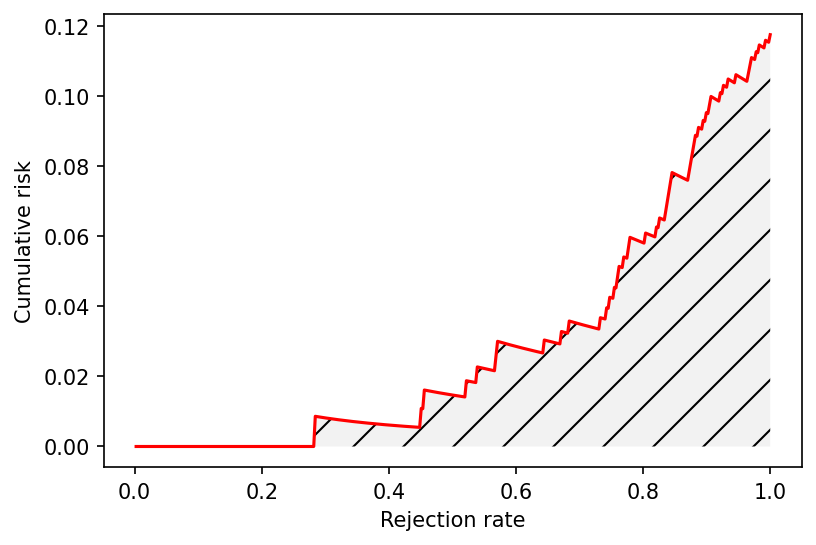

In [103]:
plt.figure(dpi=150)

plt.plot(points_x, points_y, linewidth=1.5, c='r')
plt.fill_between(points_x, np.zeros(len(points_x)), points_y, facecolor='grey', alpha=0.1, hatch='/')

plt.ylabel("Cumulative risk", fontdict={"size": 10})
plt.xlabel("Rejection rate", fontdict={"size": 10})
plt.savefig(f'../../../arc_plots/rcc_{dataset}_demo.png')  

In [48]:
res = {'ratio':ratio_list,
'deep_ensemble': de_scores.tolist(), 
'ddpp': dpp_scores.tolist(),
"mc": mc_scores.tolist(),
'md': maha_scores.tolist(),
'mdsn': mdsn_scores.tolist(),
'sr': sr_scores.tolist(),}

In [49]:
import json

with open(f'../../../arc_plots/{dataset}_data.json', 'w') as outfile:
    json.dump(res, outfile)

In [20]:
ratio_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
ratio = 2

print(f"Deep Ensemble, ratio={ratio_list[ratio]}, score={de_scores[ratio]}:")
print(f"DDPP, ratio={ratio_list[ratio]}, score={dpp_scores[ratio]}:")
print(f"MC, ratio={ratio_list[ratio]}, score={mc_scores[ratio]}:")
print(f"MD, ratio={ratio_list[ratio]}, score={maha_scores[ratio]}:")
print(f"MD SN, ratio={ratio_list[ratio]}, score={mdsn_scores[ratio]}:")
print(f"SR, ratio={ratio_list[ratio]}, score={sr_scores[ratio]}:")

Deep Ensemble, ratio=0.2, score=0.9558823529411765:
DDPP, ratio=0.2, score=0.946078431372549:
MC, ratio=0.2, score=0.9595588235294118:
MD, ratio=0.2, score=0.946078431372549:
MD SN, ratio=0.2, score=0.9522058823529411:
SR, ratio=0.2, score=0.9473039215686274:


In [21]:
dataset='cola'

In [22]:
maha_scores = []
res_path = f'../../../new_results/metric_electra_wide/{dataset}/maha/results'

for seed in os.listdir(res_path):

    with open(Path(res_path)/ seed / 'dev_inference.json') as f:
            model_outputs = json.loads(f.read())

    mahalanobis_distance = np.asarray(model_outputs['mahalanobis_distance'])
    probabilities = np.asarray(model_outputs['probabilities'])
    eval_labels = np.asarray(model_outputs['eval_labels'])

    predictions = np.argmax(probabilities, axis=-1)
    
    ensemble_answers = predictions
    sorted_indexes_ensemble = np.argsort(-mahalanobis_distance)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    maha_scores.append(ens_scores)
maha_scores = np.median(maha_scores, axis=0)

In [23]:
mdsn_scores = []
res_path = f'../../workdir/run_tasks_for_model_series_sn/electra_reg_sn/{dataset}/0.0/mahalanobis/results'

for seed in os.listdir(res_path):

    try:
        seed = str(int(seed))
    except:
        continue
        
    with open(Path(res_path)/ seed / 'dev_inference.json') as f:
            model_outputs = json.loads(f.read())

    mahalanobis_distance = np.asarray(model_outputs['mahalanobis_distance'])
    probabilities = np.asarray(model_outputs['probabilities'])
    eval_labels = np.asarray(model_outputs['eval_labels'])

    predictions = np.argmax(probabilities, axis=-1)
    
    ensemble_answers = predictions
    sorted_indexes_ensemble = np.argsort(-mahalanobis_distance)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    mdsn_scores.append(ens_scores)
mdsn_scores = np.median(mdsn_scores, axis=0)

In [24]:
dpp_scores = []
res_path = f'../../workdir/run_tasks_for_model_series/electra_metric_no_sn/{dataset}/0.0/ddpp_dpp/results'

for seed in os.listdir(res_path):
    with open(Path(res_path) / seed / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())

    probabilities = np.asarray(model_outputs["probabilities"])
    true_labels = np.asarray(model_outputs["true_labels"])
    sampled_probabilities = np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2)
    answers = np.asarray(model_outputs['answers'])

    predictions = np.argmax(probabilities, axis=-1)
    errors = (eval_labels != predictions).astype("uint8")

    smp_dpp = sampled_max_prob(sampled_probabilities)
    pv_dpp = probability_variance(sampled_probabilities)
    
    ensemble_answers = np.asarray(sampled_probabilities).mean(1).argmax(-1)
    sorted_indexes_ensemble = np.argsort(-smp_dpp)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    dpp_scores.append(ens_scores)
dpp_scores = np.median(dpp_scores, axis=0)

In [25]:
de_scores = []
res_path = f'../../../new_results/electra_wide_90_{dataset}/electra_wide_90/ensembles/final_results/0'
for seed in os.listdir(res_path):
    with open(Path(res_path) / seed / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())

    probabilities = np.asarray(model_outputs["probabilities"])
    true_labels = np.asarray(model_outputs["true_labels"])
    sampled_probabilities = np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2)
    answers = np.asarray(model_outputs['answers'])

    de_all_sampled = sampled_max_prob(sampled_probabilities)
    ensemble_answers = np.asarray(sampled_probabilities).mean(1).argmax(-1)
    sorted_indexes_ensemble = np.argsort(-de_all_sampled)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    de_scores.append(ens_scores)
de_scores = np.median(de_scores, axis=0)

In [26]:
mc_scores = []
res_path = f'../../../new_results/metric_electra_wide/{dataset}/all/results'

for seed in os.listdir(res_path):
    
    with open(Path(res_path) / seed / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())

    probabilities = np.asarray(model_outputs["probabilities"])
    true_labels = np.asarray(model_outputs["true_labels"])
    sampled_probabilities = np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2)
    answers = np.asarray(model_outputs['answers'])

    mc_all_sampled = sampled_max_prob(sampled_probabilities)
    ensemble_answers = np.asarray(sampled_probabilities).mean(1).argmax(-1)
    sorted_indexes_ensemble = np.argsort(-mc_all_sampled)
    ens_scores = [
                get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                for ratio in ratio_list
    ]
    mc_scores.append(ens_scores)
mc_scores = np.median(mc_scores, axis=0)

In [27]:
sr_scores = []
acc = []
res_path = f'../../../new_results/raw_electra_wide/{dataset}/all/results'

for seed in os.listdir(res_path):

    with open(Path(res_path) / seed / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())

    probabilities = np.asarray(model_outputs["probabilities"])
    true_labels = np.asarray(model_outputs["true_labels"])
    sampled_probabilities = np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2)
    answers = np.asarray(model_outputs['answers'])
    model_ues = 1 - np.max(probabilities, axis=1)
    model_answers = np.asarray(model_outputs['answers'])
    sorted_indexes_model = np.argsort(-model_ues)
    model_scores = [
        get_score_ratio(sorted_indexes_model, model_answers, eval_labels, ratio)
        for ratio in ratio_list
    ]
    sr_scores.append(model_scores)
    acc.append((answers==true_labels).sum() / len(answers))
sr_scores = np.median(sr_scores, axis=0)
acc = np.mean(acc)

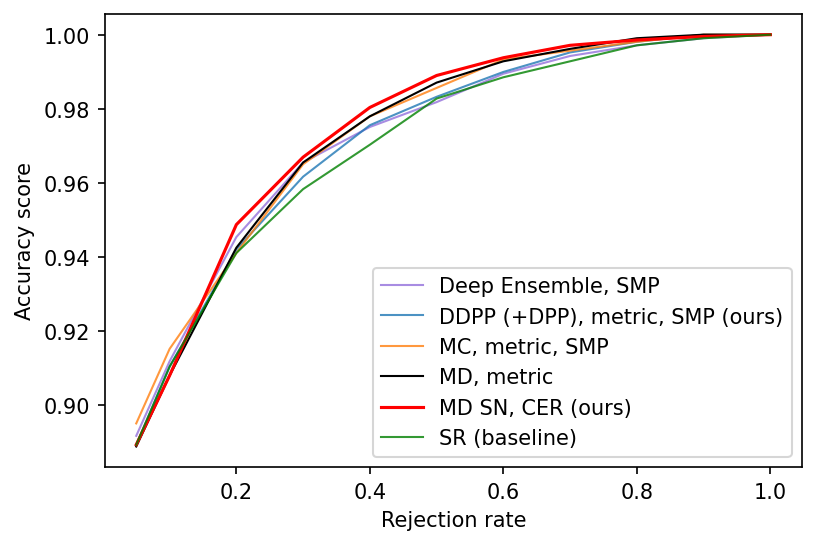

In [28]:
#plt.style.use('seaborn')

plt.figure(dpi=150)
ratio_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

plt.plot(ratio_list, de_scores, label='Deep Ensemble, SMP', linewidth=1,  c='mediumpurple', alpha=0.8)
plt.plot(ratio_list, dpp_scores, label='DDPP (+DPP), metric, SMP (ours)', linewidth=1, alpha=0.8)
plt.plot(ratio_list, mc_scores, label='MC, metric, SMP', linewidth=1, alpha=0.8)
plt.plot(ratio_list, maha_scores, label='MD, metric', linewidth=1, c='black')
plt.plot(ratio_list, mdsn_scores, label='MD SN, CER (ours)', linewidth=1.5, c='r')   
plt.plot(ratio_list, sr_scores, label="SR (baseline)", linewidth=1, c='g', alpha=0.8)

plt.ylabel("Accuracy score", fontdict={"size": 10})
plt.xlabel("Rejection rate", fontdict={"size": 10})
plt.legend()
plt.savefig(f'../../../arc_plots/{dataset}.pdf')  
plt.savefig(f'../../../arc_plots/{dataset}.png')  

In [29]:
ratio_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
ratio = 2

print(f"Deep Ensemble, ratio={ratio_list[ratio]}, score={de_scores[ratio]}:")
print(f"DDPP (+OOD), ratio={ratio_list[ratio]}, score={dpp_scores[ratio]}:")
print(f"MC dropout, ratio={ratio_list[ratio]}, score={mc_scores[ratio]}:")
print(f"MD, ratio={ratio_list[ratio]}, score={maha_scores[ratio]}:")
print(f"MD SN, ratio={ratio_list[ratio]}, score={mdsn_scores[ratio]}:")
print(f"SR, ratio={ratio_list[ratio]}, score={sr_scores[ratio]}:")

Deep Ensemble, ratio=0.2, score=0.9453499520613614:
DDPP (+OOD), ratio=0.2, score=0.9419942473633749:
MC dropout, ratio=0.2, score=0.9410354745925216:
MD, ratio=0.2, score=0.9424736337488016:
MD SN, ratio=0.2, score=0.948705656759348:
SR, ratio=0.2, score=0.9410354745925216:
